# Discrete Population Balance Model of Radical Polymerization

## 📖 Introduction

[Radical polymerization] (RP) is a type of chain-growth polymerization in which the active center is a radical. The reaction mechanism involves at least three key steps: initiation, propagation, and termination. In this case, the reaction scheme can be written as follows:

\begin{align*}
I                         & \xrightarrow{k_d}           2 I^{\cdot} \\
I^{\cdot}   + M           & \xrightarrow{\textrm{fast}} R_1^{\cdot} \\
R_n^{\cdot} + M           & \xrightarrow{k_p}           R_{n+1}^{\cdot} \\
R_n^{\cdot} + R_m^{\cdot} & \xrightarrow{k_{tc}}        P_{n+m} \\
R_n^{\cdot} + R_m^{\cdot} & \xrightarrow{k_{td}}        P_n + P_m
\end{align*}

For a closed system with constant volume and constant rate coefficients, the corresponding transient species balances are:

\begin{align}
\frac{\textrm{d}[I]}{\textrm{d}t} & = - k_d [I] \\
\frac{\textrm{d}[M]}{\textrm{d}t} & = - k_p [M] \sum_{j=1}^{\infty}[R^{\cdot}_{j}] - 2 f k_d [I] \\
\frac{\textrm{d}[R^{\cdot}_{n}]}{\textrm{d}t} & = k_p[M]\left([R^{\cdot}_{n-1}]-[R^{\cdot}_{n}]\right)- 2 (k_{tc} + k_{td}) [R^{\cdot}_{n}] \sum_{j=1}^{\infty}[R^{\cdot}_{j}] + \delta_{n,1}2fk_d[I] \\
\frac{\textrm{d}[P_n]}{\textrm{d}t} & = k_{tc} \sum_{j=1}^{n-1}[R^{\cdot}_{n-j}][R^{\cdot}_{j}] + 2 k_{td} [R^{\cdot}_{n}] \sum_{j=1}^{\infty}[R^{\cdot}_{j}]
\end{align}

By defining an appropriate upper limit for the chain length $N$, we obtain a closed system of $2N+2$ ordinary differential equations (ODEs). However, numerically solving this ODE system is challenging. Under typical polymerization conditions, very long chains are formed, requiring rather large $N$ values (possibly $10^4$–$10^5$ or higher). Moreover, the presence of short-lived radical species makes the ODE system stiff, requiring implicit solvers.

Special numerical methods are therefore needed to solve the population balances efficiently and stably. You can read about it [here](https://onlinelibrary.wiley.com/doi/abs/10.1002/mren.202000010). In this tutorial, we integrate the discrete population balances directly. This brute-force approach is quite inefficient (be prepared to wait 10–60 s, depending on CPU performance), but it serves a pedagogical purpose by providing transparency in its workings.

[Radical polymerization]: https://en.wikipedia.org/wiki/Radical_polymerization

## 🧮 Model Implementation

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from numba import jit, prange
from scipy.integrate import solve_ivp

First, we implement separate functions to compute the differential mole balances for each of the three reaction steps. All functions are JIT-compiled with [Numba] to improve performance (we need all the help we can!).

```{note}
When used properly, [Numba] can generate highly optimized machine code, achieving performance close to that of statically typed languages. However, debugging Numba-decorated functions can be challenging. Therefore, it is best to activate Numba **only after** ensuring that the underlying Python function works as intended.   
```

[Numba]: https://numba.pydata.org/

In [ ]:
@jit(fastmath=True)
def initiation(I: float,
               M: float,
               kd: float,
               f: float
               ) -> tuple[float, float, float]:
    """Initiation balances.

    I -> 2 I*      , kd
    I* + M -> R1   , fast

    d[I]/dt = -kd*[I]
    d[M]/dt = -2*f*kd*[I]
    d[R1]/dt = 2*f*kd*[I]

    Parameters
    ----------
    I : float
        Initiator concentration.
    M : float
        Monomer concentration.
    kd : float
        Initiator decomposition rate coefficient.
    f : float
        Initiation efficiency.

    Returns
    -------
    tuple[float, float, float]
        Molar balances for I, M and R1.
    """
    Idot = -kd*I
    ri = 2*f*kd*I*(M/(M + 1e-10))
    Mdot = -ri
    R1dot = ri
    return Idot, Mdot, R1dot

In [3]:
@jit(fastmath=True, parallel=True)
def propagation(R: np.ndarray,
                M: float,
                kp: float
                ) -> tuple[float, np.ndarray]:
    """Propagation balances.

    R(n) + M -> R(n+1) , kp

    d[Rn]/dt = kp*[M]*([Rn-1] - [Rn])
    d[M]/dt = -kp*[M]*sum([Rn])

    Parameters
    ----------
    R : np.ndarray
        Radical concentrations.
    M : float
        Monomer concentration.
    kp : float
        Propagation rate coefficient.

    Returns
    -------
    tuple[float, np.ndarray]
        Molar balances for M and Rn.
    """
    Mdot = -kp*M*R.sum()
    Rdot = np.zeros_like(R)
    for i in prange(1, R.size):
        Rdot[i] = kp*M*(R[i-1] - R[i])
    return Mdot, Rdot

In [4]:
@jit(fastmath=True, parallel=True)
def termination(R: np.ndarray,
                ktc: float,
                ktd: float
                ) -> tuple[float, np.ndarray]:
    """Termination balances.

    R(n) + R(m) -> P(n+m)      , ktc
    R(n) + R(m) -> P(n) + P(m) , ktd

    d[Rn]/dt = -2*(ktc + ktd)*[Rn]*[R]
    d[Pn]/dt = ktc * sum i=1:n-1 [Rn-i]*[Ri] + 2*ktd*[Rn]*[R]

    Parameters
    ----------
    R : np.ndarray
        Radical concentrations.
    ktc : float
        Termination by combination rate coefficient.
    ktd : float
        Termination by disproportionation rate coefficient.

    Returns
    -------
    tuple[float, np.ndarray]
        Molar balances for Rn and Pn.
    """
    # d[Rn]/dt
    Rdot = -2*(ktc + ktd)*R*R.sum()
    # d[Pn]/dt
    Pdot = np.zeros_like(R)
    if ktc > 0.0:
        for n in prange(2, R.size):
            accum = 0.0
            for i in range(1, n):
                accum += R[i]*R[n-i]
            Pdot[n] = accum
        Pdot *= ktc
    Pdot += 2*ktd*R*R.sum()
    return Rdot, Pdot

Next, we combine all the reaction steps into a function that evaluates the total rate of change of the [state vector] $\boldsymbol{x}$, which contains the concentrations of all species.

[state vector]: https://en.wikipedia.org/wiki/State-space_representation

In [5]:
@jit(fastmath=True, parallel=True)
def model_xdot(t: float,
               x: np.ndarray,
               kd: float,
               kp: float,
               ktc: float,
               ktd: float,
               f: float,
               N: int
               ) -> np.ndarray:
    """Calculate derivative of the state vector, dx/dt.

    x = [I, M, R_0..R_N, P_0..P_N]

    Parameters
    ----------
    t : float
        Time.
    x : np.ndarray
        State vector.
    kd : float
        Initiator decomposition rate coefficient.
    kp : float
        Propagation rate coefficient.
    ktc : float
        Termination by combination rate coefficient.
    ktd : float
        Termination by disproportionation rate coefficient.
    f : float
        Initiation efficiency.
    N : int
        Maximum chain length.

    Returns
    -------
    np.ndarray
        Time derivative of the state vector.
    """
    # Unpack the state vector
    I = x[0]
    M = x[1]
    R = x[2:N+3]
    # P = y[N+3:]

    # Compute the kinetic steps
    Idot, Mdot, R1dot = initiation(I, M, kd, f)
    Mdot_, Rdot = propagation(R, M, kp)
    Mdot += Mdot_
    Rdot_, Pdot = termination(R, ktc, ktd)
    Rdot += Rdot_
    Rdot[1] += R1dot
    
    # Assemble the derivative vector
    xdot = np.empty_like(x)
    xdot[0] = Idot
    xdot[1] = Mdot
    xdot[2:N+3] = Rdot
    xdot[N+3:] = Pdot
    
    return xdot

Finally, we perform the numerical integration using a suitable ODE solver. This system is _very_ [stiff](https://en.wikipedia.org/wiki/Stiff_equation), therefore we need to chose an implicit solver like `LSODA`.

In [6]:
def solve_model(I0: float,
                M0: float,
                kd: float,
                f: float,
                kp: float,
                ktc: float,
                ktd: float,
                N: int,
                tend: float
                ) -> tuple[np.ndarray, ...]:
    """Solve the dynamic model.

    Parameters
    ----------
    I0 : float
        Initial initiator concentration (mol/L).
    M0 : float
        Initial monomer concentration (mol/L).
    kd : float
        Initiator decomposition rate coefficient (1/s).
    f : float
        Initiation efficiency.
    kp : float
        Propagation rate coefficient (L/(mol·s)).
    ktc : float
        Termination by combination rate coefficient (L/(mol·s)).
    ktd : float
        Termination by disproportionation rate coefficient (L/(mol·s)).
    N : int
        Maximum chain length.
    tend : float
        End time (s).

    Returns
    -------
    tuple[np.ndarray, ...]
        Time, chain lengths, I, M, Rn, Pn.
    """

    # Chain lengths (include length 0, to make indexing easier)
    s = np.arange(0, N+1)

    # Initial conditions
    R0 = np.zeros_like(s)
    P0 = np.zeros_like(s)
    x0 = np.concatenate(([I0], [M0], R0, P0))

    # Solve ODE set
    teval = np.linspace(0.0, tend, num=100+1)
    atol = np.concatenate(
        ([1e-6], [1e-6], 1e-11*np.ones_like(R0), 1e-7*np.ones_like(P0)))

    solution = solve_ivp(model_xdot,
                         t_span=(0.0, tend),
                         y0=x0,
                         t_eval=teval,
                         args=(kd, kp, ktc, ktd, f, N),
                         method='LSODA',  # implicit solver is a MUST
                         rtol=1e-3,
                         atol=atol)

    # Unpack the solution
    t = solution.t
    x = solution.y
    I = x[0, :]
    M = x[1, :]
    R = x[2:N+3, :]
    P = x[N+3:, :]

    return t, s, I, M, R, P

## ▶️ Run Simulation

Let's start with some educated guesses, while being carefull not to make very long chains.

In [7]:
# Parameters
f = 0.5
kd = 4e-4  # 1/s
kp = 4e3   # L/(mol·s)
ktc = 1e8  # L/(mol·s)
ktd = 1e8  # L/(mol·s)

# Initial concentrations
M0 = 1.0   # mol/L
I0 = 1e-2  # mol/L

# Simulation time
tend = 3600  # s

# Maximum chain length
N = 1000

The initial kinetic chain length informs us about the average degree of polymerization of the macroradicals. `N` must be well above this value, otherwise chains escape the numerical domain.

In [8]:
kinetic_chain_length = kp/(2*np.sqrt(f*kd*(ktc+ktd))) * M0/np.sqrt(I0)

print(f"The kinetic chain length is {kinetic_chain_length:.0f}.")
if (N < 5*kinetic_chain_length):
    answer = "insufficient"
else:
    answer = "sufficient"
print(f"N={N} appears {answer}.")

The kinetic chain length is 100.
N=1000 appears sufficient.


Here we go! This might take a while, depending on how large $N$ is.

In [9]:
t, s, I, M, R, P = solve_model(I0, M0, kd, f, kp, ktc, ktd, N, tend)

By the way, can you pinpoint which part of the code is the rate-limiting step?

## 📊 Plots

### Reactants

Below are visualizations showing how the initiator and monomer concentrations evolve over time.

Text(0.5, 23.52222222222222, 'Time (s)')

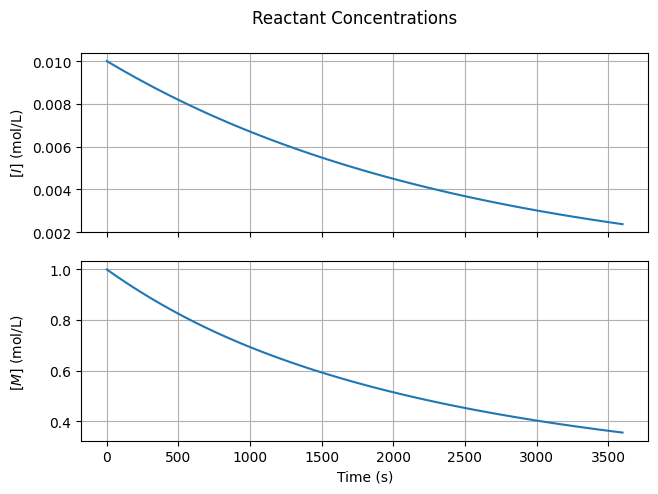

In [10]:
fig1, ax = plt.subplots(2, 1, sharex=True)
fig1.suptitle("Reactant Concentrations")
fig1.tight_layout()
fig1.align_ylabels()

# [I] on the first subplot
ax[0].plot(t, I)
ax[0].set_ylabel(r"$[I]$" + " (mol/L)")
ax[0].grid(True)

# [M] on the second subplot
ax[1].plot(t, M)
ax[1].set_ylabel(r"$[M]$" + " (mol/L)")
ax[1].grid(True)

ax[-1].set_xlabel("Time (s)")

### Moments

Below are visualizations that show how the characteristic moments and related averages of the radical and polymer distributions evolve over time.

In [11]:
def moment(Q: np.ndarray, m: int) -> np.ndarray:
    "m-th moment of `Q`"
    s = np.arange(0, Q.shape[0])
    return np.dot(s**m, Q)

Mass balance error: 3.1e-04


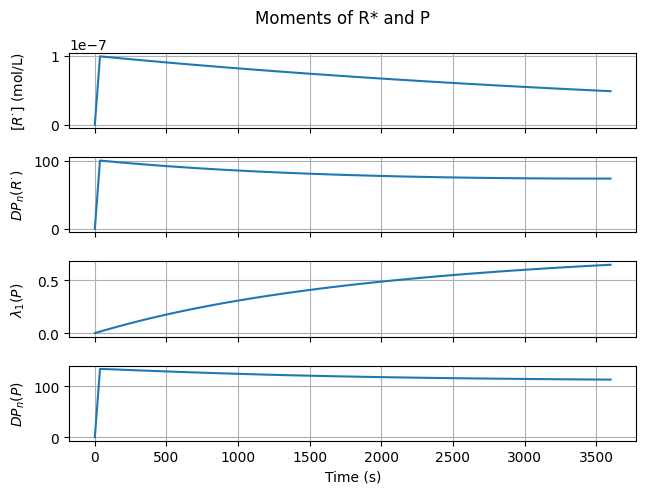

In [12]:
fig2, ax = plt.subplots(4, 1, sharex=True)
fig2.suptitle("Moments of R* and P")
fig2.tight_layout()
fig2.align_ylabels()

eps = np.finfo(float).eps

# 0-th moment of R*
r0 = moment(R, 0)
ax[0].plot(t, r0)
ax[0].set_ylabel(r"$[R^{\cdot}]$" + " (mol/L)")
ax[0].grid(True)

# Number-average degree of polymerization of R*
r1 = moment(R, 1)
DPn_R = r1 / (r0 + eps)
ax[1].plot(t, DPn_R)
ax[1].set_ylabel(r"$DP_n(R^{\cdot})$")
ax[1].grid(True)

# 1st moment of P
p1 = moment(P, 1)
ax[2].plot(t, p1)
ax[2].set_ylabel(r"$\lambda_1(P)$")
ax[2].grid(True)

# Number-average degree of polymerization of P
p0 = moment(P, 0)
DPn = p1 / (p0 + eps)
ax[3].plot(t, DPn)
ax[3].set_ylabel(r"$DP_n(P)$")
ax[3].grid(True)

ax[-1].set_xlabel("Time (s)")

mass_balance_error = np.max(np.abs((r1 + p1 + M)/M0 - 1.0))
print(f"Mass balance error: {mass_balance_error:.1e}")

The mass balance error is of the same order as the relative tolerance specified in the ODE solver, suggesting that the solution is consistent.

### Chain Length Distribution

And finally, the number chain length distributions of the radicals and dead polymer.

Text(0.5, 23.52222222222222, 'Chain length')

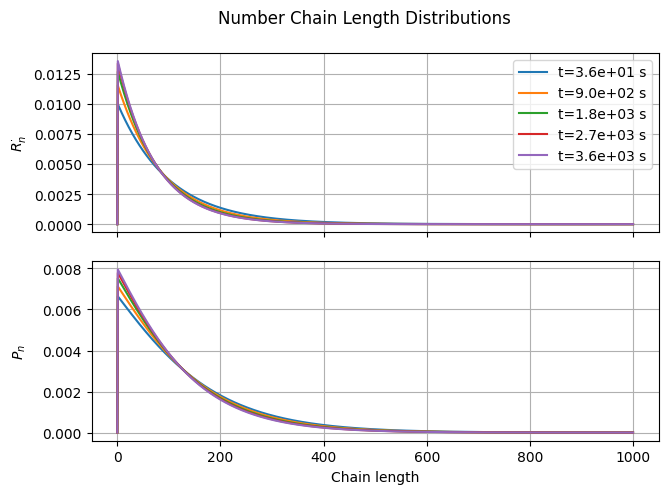

In [13]:
fig3, ax = plt.subplots(2, 1, sharex=True)
fig3.suptitle("Number Chain Length Distributions")
fig3.tight_layout()
fig3.align_ylabels()

# Normalize Rn and Pn by peak and plot them
for i, (Y, Yname) in enumerate(zip([R, P], [r"$R^{\cdot}_n$", r"$P_n$"])):
    for ii in [1, int(0.25*len(t)), int(0.5*len(t)), int(0.75*len(t)), -1]:
        y = Y[:, ii].copy()
        y /= (y.sum() + eps)
        ax[i].plot(s, y, label=f"t={t[ii]:.1e} s")
    ax[i].set_ylabel(Yname)
    ax[i].grid(True)

ax[0].legend(loc="best")
ax[-1].set_xlabel("Chain length")

## 🔎 Questions

1. What is the relationship between the average degree of polymerization of $R^{\cdot}$ and $P$?
2. What is the physical meaning of the 1st moment of $P$?
3. What system property did we use to check the mass balance error? 
4. What kind of distribution does $R^{\cdot}$ follow? And what about $P$?
5. Calculate $[R^{\cdot}]$ using the quasi-steady state approximation, and compare it to the value obtained by solving the transient radical balances.